In [1]:
import os, sys
import pickle
import polars as pl

In [2]:
# Define el ID del experimento que quieres analizar
DATA_ID = 'heart_disease' 
N_REALIZATIONS = 100

project_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..')) 
results_dir = os.path.join(project_path, 'results', 'experiment_3', DATA_ID)
filename = f'results_exp_3_{DATA_ID}.pkl'
results_path = os.path.join(results_dir, filename)

sys.path.append(project_path)

from src.experiments_utils import plot_experiment_3_results
#from config.config_experiment_3 import N_REALIZATIONS

In [3]:
# -------------------------------------------------------------------------
# CARGAR RESULTADOS
# -------------------------------------------------------------------------
if not os.path.exists(results_path):
    print("❌ Error: El archivo no existe. Revisa el DATA_ID o la ruta.")
else:
    with open(results_path, 'rb') as f:
        results = pickle.load(f)
    print(f"✅ Archivo cargado correctamente. Tipo de objeto: {type(results)}")
    print(f"📊 Número de realizaciones (seeds) capturadas: {len(results)}")

# -------------------------------------------------------------------------
# CONVERSIÓN A DATAFRAME  
# -------------------------------------------------------------------------
rows = []
for seed, metrics in results.items():   
    # Asumimos que todas las métricas tienen las mismas claves (frac_sample_sizes)
    n_splits_arr = metrics['ARI'].keys() 
    frac_sample_size_arr = metrics['ARI'][list(n_splits_arr)[0]].keys()
    
    for n_splits in n_splits_arr:
        for frac in frac_sample_size_arr:        
            row = {
                'random_state': seed,
                'n_splits': n_splits,
                'frac_sample_size': frac,
                'time': metrics['time'].get(n_splits).get(frac),
                'adj_accuracy': metrics['adj_accuracy'].get(n_splits).get(frac),
                'ARI': metrics['ARI'].get(n_splits).get(frac)
            }
            rows.append(row)

df = pl.DataFrame(rows)

✅ Archivo cargado correctamente. Tipo de objeto: <class 'dict'>
📊 Número de realizaciones (seeds) capturadas: 5


In [4]:
df

random_state,n_splits,frac_sample_size,time,adj_accuracy,ARI
i64,i64,f64,f64,f64,f64
428,3,0.2,1.407115,0.653199,0.090656
428,3,0.3,1.446717,0.585859,0.02593
428,3,0.4,1.425825,0.619529,0.053484
428,3,0.5,1.488873,0.622896,0.056419
428,3,0.6,1.631662,0.686869,0.136611
…,…,…,…,…,…
2183,10,0.5,4.314692,0.552189,0.006428
2183,10,0.6,4.246966,0.720539,0.191835
2183,10,0.7,3.946929,0.626263,0.06036


In [6]:
df_avg = (
    df.group_by(['n_splits', 'frac_sample_size'])
    .agg(pl.mean(['ARI', 'adj_accuracy', 'time']))
    .sort(['n_splits', 'frac_sample_size'])
)

df_avg

n_splits,frac_sample_size,ARI,adj_accuracy,time
i64,f64,f64,f64,f64
3,0.2,0.077026,0.627609,1.475907
3,0.3,0.115846,0.643771,1.457624
3,0.4,0.137185,0.668013,1.494438
3,0.5,0.137881,0.6633,1.545186
3,0.6,0.126975,0.67138,1.522899
…,…,…,…,…
10,0.5,0.056176,0.608754,4.087717
10,0.6,0.093333,0.645118,4.06698
10,0.7,0.092355,0.638384,4.001956


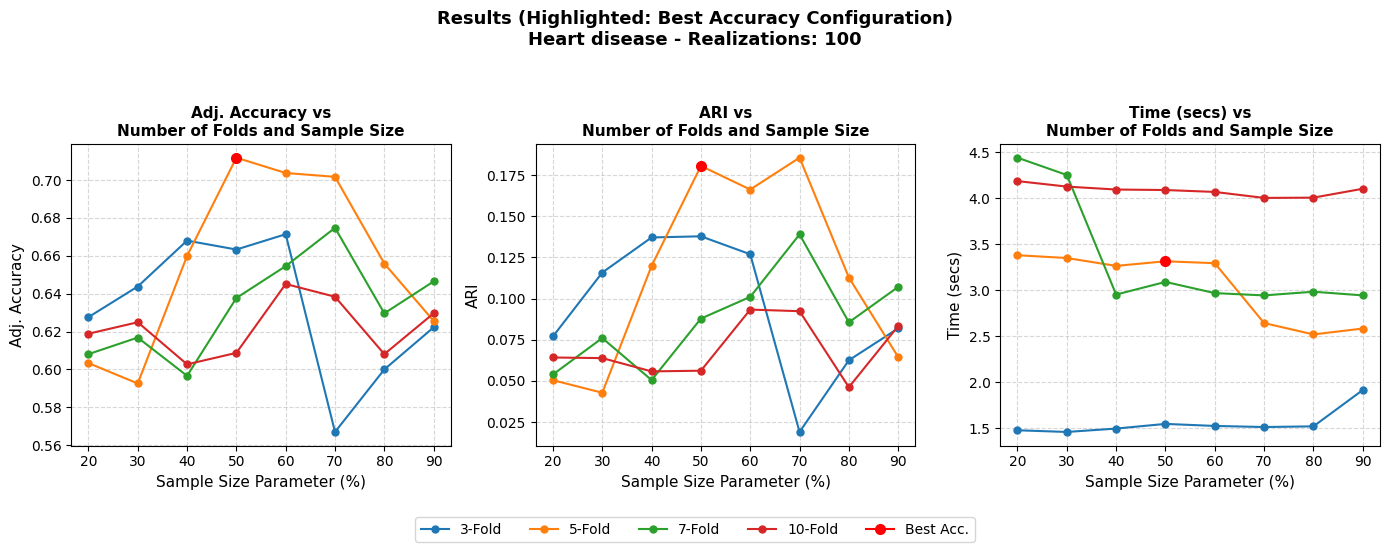

In [7]:
plot_filename = f'plot_results_exp_multifold_{DATA_ID}.png'
save_path = os.path.join(results_dir, plot_filename)

# LLAMADA A LA FUNCIÓN
plot_experiment_3_results(
    df=df_avg,                  
    data_name=DATA_ID,          
    num_realizations=100,       
    save_path=save_path
)